1.   Input new transaction
2.   Reporting Menu
3.   Save Changes to data
0.   Exit

Select option : 2
-------------  -------
John Smyth     -294.74
Missy May      -520.08
Susie Sue      -140
Boris Johnson   125
Jane Doe         89
Joe Bloggs      220
Leo Varadker    110
-------------  -------
1.   Input new transaction
2.   Reporting Menu
3.   Save Changes to data
0.   Exit

Select option : 0


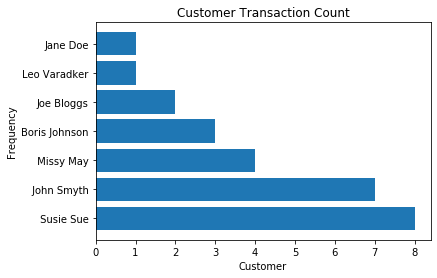

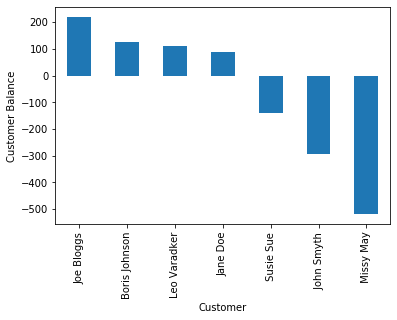

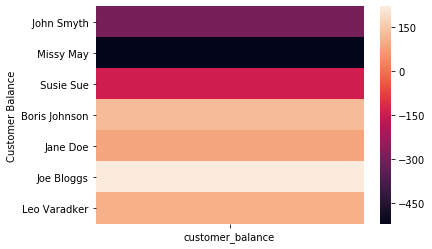

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  4 18:35:28 2019

@author: sebst
"""


import pandas as pd
import numpy as np
import sys
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


change_made = False 

def read_bills():
    ### Note : there should be no duplicates in the data so drop duplicates has been used
   return((pd.read_csv("bills.csv", names = ['company', 'customer', 'year', 'month', 'day', 'amount', 'credit/debit'], header = None).drop_duplicates()))
    

def enter_provider():
    while True:
        new_company = input("Enter provider : ")
        if len(df[df['company'].str.strip() == new_company]) != 0:    
            break
    return(new_company)

def enter_customer():
    while True:
        new_customer = input("Enter customer : ")
        if len(df[df['customer'].str.strip() == new_customer]) != 0:
            return(new_customer)

        while True:
            add_customer = input("Unknown Customer - Add new customer [Y/N] : ")
            if add_customer.upper() == "Y" or add_customer.upper() == "N":
                break
            
        if add_customer.upper() == "Y":
            return(new_customer)
 
def enter_date():
    while True:
        date_entry = input('Enter a date in YYYY-MM-DD format : ')
        try:
            year, month, day = map(int, date_entry.split('-'))
            date1 = datetime.date(year, month, day)
            break
        except:
            print("Error")
    return(date1)
    

def enter_amount():
    while True:
        number_entry = input("Enter Amount [-ve indicates payment] : ")
        try:
            val_number_entry = float(number_entry)
            break
        except:
            print("Enter valid number ")
            
    return(round(val_number_entry,2))
            

           
def enter_new_trans(p_df):
    global change_made
    new_company = enter_provider()
    new_customer = enter_customer()
    new_date = enter_date()
    new_amount = enter_amount()  
    if new_amount < 0:
        new_cr_db = 'credit'
        new_amount = new_amount * -1
    else:
        new_cr_db = 'debit'
    p_df = p_df.append({'company' : new_company, 'customer' : new_customer, 'year' : new_date.year, 'month' : new_date.month, 'day' : new_date.day, 'amount' : new_amount, 'credit/debit' : new_cr_db}, ignore_index = True)    
    change_made = True
    return(p_df)
                
def save_data(p_df):
    while True:
        try:
            p_df.to_csv(path_or_buf = "bills.csv", index = False, header = False)
            break
        except:
            try_again = input("Error saving data - Try Again [Y/N] ").upper()
            if try_again == "N":
                break
            
def horizontal_barchart(p_df):
    fig, axs = plt.subplots()

    data = p_df['customer'].value_counts()
    # get x and y data 
    points = data.index 
    frequency = data.values 
    # create bar chart 
    axs.barh(points, frequency) 
    # set title and labels 
    axs.set_title('Customer Transaction Count') 
    axs.set_xlabel('Customer') 
    axs.set_ylabel('Frequency')
    ###ax.show()    

    
def plot_account_sums(p_df):
    fig, axs = plt.subplots()
    p_df['customer_balance'] = np.where (p_df['credit/debit'] == 'debit', p_df['amount'], 0 - p_df['amount'])
    table = p_df.groupby(['customer'])[["customer_balance"]].sum()
    p_df.groupby("customer").customer_balance.sum().sort_values(ascending=False).plot.bar(ax = axs)
    axs.set_xlabel("Customer")
    axs.set_ylabel("Customer Balance")
    
def seaborn_heatmap(p_df):
    fig, axs = plt.subplots()
    p_df['customer_balance'] = np.where (p_df['credit/debit'] == 'debit', p_df['amount'], 0 - p_df['amount'])
    table = p_df.groupby(['customer'])[["customer_balance"]].sum()
    axs = sns.heatmap(p_df.groupby('customer').sum()[['customer_balance']])
    axs.set_ylabel("Customer Balance")
    
def tabulate_by_customer(p_df):
    ###p_df['customer_balance'] = p_df['credit/debit'].apply(lambda x: p_df['amount'] if x == 'Debit' else 0 - p_df['amount'])    
    p_df['customer_balance'] = np.where (p_df['credit/debit'] == 'debit', p_df['amount'], 0 - p_df['amount'])
    table = p_df.groupby(['customer'])[["customer_balance"]].sum()
    print(tabulate(table))
    
def tabulate_by_year(p_df):
    p_df['debit'] = np.where (p_df['credit/debit'] == 'debit', p_df['amount'], 0)
    p_df['credit'] = np.where (p_df['credit/debit'] == 'credit', p_df['amount'], 0)
    
def menu_logic(p_df):
    global change_made
    clear = lambda: os.system('cls') #on Windows System
    while True:
        clear()
        print("1.   Input new transaction")
        print("2.   Reporting Menu")
        print("3.   Save Changes to data")
        print("0.   Exit")
        print("")
        input_option = int(input("Select option : "))
        if input_option == 0:
            while True:
                if change_made == False:
                    break
                save_changes_yn = input("Save Changes [Y/N] : ").upper()
                if save_changes_yn == "Y":
                    save_data(p_df)
                    break
                elif save_changes_yn == "N":
                    break
            break
        elif input_option == 1:
            p_df = enter_new_trans(p_df)
            print(p_df)
        elif input_option == 3:
            save_data(p_df)
        elif input_option == 2:           
            horizontal_barchart(p_df)
            plot_account_sums(p_df)
            seaborn_heatmap(p_df)
            tabulate_by_customer(p_df)

df = read_bills() 
menu_logic(df)

